# Анализ оттока клиентов в Метанпромбанке

**Цель проекта:** провести анализ, который поможет понять какие клиенты уходят из банка и выделить сегменты клиентов, склонные уходить из банка.

**Заказчик исследования** - отдел маркетинга банка Метанпромбанк 

**Источник данных** - датасет c данными о клиентах банка, предоствлен самим банком.

**Задачи исследования:**
1. Провести исследовательский анализ данных.
2. Составить портреты клиентов, которые склонны уходить из банка.
3. Проверить статистические гипотезы:
    - гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались
    - гипотезу о различии дохода между клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним
    - возможно, в процессе исследования сформулируем новую гипотезу в качестве дополнительной или взамен вышеописанным

## Обзор данных

### Описание полей датасета

- `USERID` — идентификатор пользователя
- `score` — баллы кредитного скоринга
- `city` — город
- `gender` — пол
- `age` — возраст
- `equity` — количество баллов собственности
- `balance` — баланс на счёте
- `products` — количество продуктов, которыми пользуется клиент
- `credit_card` — есть ли кредитная карта
- `last_activity` — активный клиент
- `EST_SALARY` — оценочный доход клиента
- `сhurn` — признак оттока

### Общая информация

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import ttest_ind, levene
import plotly.graph_objs as go
from plotly.offline import iplot
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Преднастройки
plt.style.use('seaborn-pastel')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Читем датасет
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

# Выведем первые 10 строк датасета
df.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1
5,202305,856.00,Рыбинск,М,56.00,4,"863,687.24",3,1,0,"156,619.80",0
6,177259,807.00,Ярославль,Ж,39.00,3,"405,042.44",3,0,1,"103,838.32",0
7,218868,825.00,Ярославль,Ж,38.00,4,"458,145.40",2,1,1,"68,085.48",0
8,211686,923.00,Ярославль,М,54.00,5,"1,206,337.87",2,1,0,"155,371.79",0
9,133130,906.00,Ярославль,Ж,67.00,0,NaN,1,0,1,"238,055.53",0


In [4]:
# Посмотрим на общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


- Размер датасета - 12 колонок, 10 000 строк
- Наблюдаются пропуски в колонках `age` и `balance`
- Назвавния колонок в разном регистре
- Для колонок `score` и `age` больше подошел бы целочисленный тип данных

In [5]:
# Проверим основные статистические показатели
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,"10,000.00","10,000.00","9,974.00","10,000.00","7,705.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"171,814.71",848.70,42.73,2.63,"827,794.31",1.87,0.68,0.52,"147,866.89",0.18
std,"33,708.24",65.45,12.18,1.98,"1,980,614.15",0.79,0.47,0.50,"139,388.51",0.39
min,"94,561.00",642.00,18.00,0.00,0.00,0.00,0.00,0.00,"2,546.30",0.00
25%,"142,810.25",802.00,33.00,0.00,"295,554.16",1.00,0.00,0.00,"75,251.90",0.00
50%,"172,728.00",853.00,40.00,3.00,"524,272.20",2.00,1.00,1.00,"119,658.10",0.00
75%,"201,261.75",900.00,51.00,4.00,"980,705.85",2.00,1.00,1.00,"174,500.54",0.00
max,"229,145.00","1,000.00",86.00,9.00,"119,113,552.01",5.00,1.00,1.00,"1,395,064.45",1.00


- Отрицательные значения отсутствуют
- Средний отток по банку - 18,2%
- Присутствует аномальное нулевое значение в столбце `products` 

### Выводы

- Размер датасета - 12 колонок, 10 000 строк
- Наблюдаются пропуски в колонках `age` и `balance`
- Назвавния колонок в разном регистре - необходимо будет привести их к единому стилю 
- Колонки `score` и `age` необходимо привести к целочисленному типу данных
- Отрицательные значения отсутствуют
- Средний отток по банку - 18,2%

## Предобработка данных

### Приведение наименований столбцов к единому стилю

In [6]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

# Переименуем столбцы 'userid' и 'est_salary'
df = df.rename({'userid': 'user_id', 'est_salary': 'estimated_salary'}, axis=1)
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'estimated_salary',
       'churn'],
      dtype='object')

### Исправление типов данных

In [7]:
df[['age','score']]

,age,score
0,25.00,850.00
1,37.00,861.00
2,30.00,892.00
3,51.00,866.00
4,34.00,730.00
...,...,...
9995,27.00,814.00
9996,46.00,894.00
9997,24.00,903.00
9998,68.00,777.00


In [8]:
# Приведем колонки `score` и `age` к целочисленному типу данных
df['age'] = df['age'].astype('Int64')
df['score'] = df['score'].astype('Int64')

# Проверим результат
df[['age','score']].dtypes

age      Int64
score    Int64
dtype: object

### Кодирование категориальных признаков

Закодируем значения столбцов `city` и `gender` для оценки корреляции в следующих разделах.

In [9]:
# Предварительно сделаем копии категориальных столбцов
df['city_2'] = df['city']
df['gender_2'] = df['gender']

# Проведем кодирование
df = pd.get_dummies(df, columns = ['city_2', 'gender_2'])

# Приведем названия новых столбцов к нужному стилю написания
df = df.rename(columns=({
    'city_2_Ростов':    'city_rostov', 
    'city_2_Рыбинск':   'city_rybinsk',
    'city_2_Ярославль': 'city_yaroslavl', 
    'gender_2_Ж':       'female', 
    'gender_2_М':       'male'
}))

df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
0,183012,850,Рыбинск,Ж,25,1,"59,214.82",2,0,1,"75,719.14",1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,"850,594.33",3,1,0,"86,621.77",0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,"107,683.34",0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,"1,524,746.26",2,0,1,"174,423.53",1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,"67,353.16",1,0,0,1,0,1


### Обработка пропусков

In [10]:
# Детализируем информацию по пропускам
df.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                   26
equity                 0
balance             2295
products               0
credit_card            0
last_activity          0
estimated_salary       0
churn                  0
city_rostov            0
city_rybinsk           0
city_yaroslavl         0
female                 0
male                   0
dtype: int64

Наблюдаем пропуски по колонкам:
- 0,26% - в столбце `age`
- 22,95% - в столбце `balance`

Далее классифицируем пропуски для принятия решения о способе их обработки.

In [11]:
# Проверим корреляцию пропусков в стобце "age" со значениями из всех остальных столбцов
df_corr = df.drop('user_id', axis=1)
df_corr.assign(missing = df_corr.age.isna()).corr()['missing'].drop('missing').sort_values(ascending=False, key=abs)

products           -0.03
equity             -0.03
last_activity       0.03
city_rybinsk        0.02
churn              -0.02
city_rostov        -0.02
estimated_salary    0.01
credit_card         0.01
city_yaroslavl     -0.01
balance             0.01
score               0.01
male                0.00
female             -0.00
age                  NaN
Name: missing, dtype: float64

Наблюдаем слабую корреляцию пропусков в стобце `age` со значениями из остальных столбцов - от 0,03 и менее в абсолютном выражении. В сочетании с малым их количеством, 0,26% от общего количества строк, позволяет с уверенностю принять решение об удалении строк с пропусками в столбце `age`.

Класс пропуска - `MCAR` — пропуски не зависят от переменных и не ведут к систематической ошибке, но увеличивают случайную ошибку, можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными.

In [12]:
# Удаляем строки с пропусками в столбце "age"
df = df.dropna(subset = ['age'])

# Проверяем результат
df['age'].isna().sum()

0

In [13]:
# Проверим корреляцию пропусков в стобце "balance" со значениями из всех остальных столбцов
df.assign(missing = df.balance.isna()).corr()['missing'].drop('missing').sort_values(ascending=False, key=abs)

equity             -0.71
products           -0.49
estimated_salary    0.31
churn              -0.25
credit_card         0.16
score               0.14
male                0.06
female             -0.06
city_rostov        -0.06
city_yaroslavl      0.06
age                -0.03
last_activity       0.03
city_rybinsk       -0.01
user_id             0.00
balance              NaN
Name: missing, dtype: float64

Наблюдаем сильную корреляцию пропусков в стобце `balance` со значениями из некоторых столбцов датасета, которая достигает 0,71 в абсолютном выражении. В сочетании с большим их количеством, а именно - 22,95% от общего количества строк, позволяет с уверенностю принять решение о необходимости оставить пропуски в столбце `balance` без обработки.

Т.е в данном случае имеем класс пропуска - `MNAR`, пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

### Обработка аномальных значений

На этапе обзора данных мы обнаружили в столбце `products` нулевое значение. Детализируем эту информацию.

In [14]:
df[df['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,"25,063.96",1,0,1,0,1,0


Наблюдаем единственного клиента с нулевым количеством банковских продуктов. 
Удалим эту анамолию.

In [15]:
df = df[df['products'] != 0]

### Проверка на дубликаты

In [16]:
# Проверим полные дубликаты
df.duplicated().sum()

0

In [17]:
# Проверим неявные дубликаты по колонке `user_id`
df['user_id'].duplicated().sum()

50

Наблюдаем 50 дубликатов. 

Чтобы их удалить нужно убедиться, что это один и тот же человек - а для этого посмотрим совпадают ли у них возвраст и пол.

In [18]:
df.duplicated(['user_id', 'gender', 'age']).sum()

2

Только у двух записей совпали возраст и пол, детализируем эти строки.

In [19]:
df[df.duplicated(['user_id', 'gender', 'age'], False)]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,estimated_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,female,male
3274,155765,863,Ярославль,М,30,5,"1,036,114.50",5,1,1,"150,744.50",1,0,0,1,0,1
5197,155765,923,Рыбинск,М,30,0,NaN,1,1,1,"120,296.60",0,0,1,0,0,1
8205,227795,840,Рыбинск,М,34,2,"350,768.03",1,1,0,"102,036.14",1,0,1,0,0,1
8497,227795,839,Ярославль,М,34,2,"326,593.14",2,1,0,"103,314.92",0,0,0,1,0,1


Данные в дубликатах отличаются. Вполне вероятно, что это один и тот же человек, просто сменил офис (город) обслуживания. 

Поэтому будет целесообразно не удалять выявленные дубликаты, а оставить их как есть - анализу они не помешают.

Дополнительно проверим - есть ли дубликаты по `user_id` в разрезе городов.

In [20]:
df.duplicated(['user_id','city']).sum()

0

Дубликаты по `user_id` в разрезе городов отсутствуют, т.е. уникальность идентификатора пользователя гарантируется только в рамках одного города. Этот факт необходимо будет учитывать при анализе.

### Выводы

- Привели наименования столбцов к единому стилю.
- Привели колонки `score` и `age` к целочисленному типу данных.
- Закодировали значения столбцов `city` и `gender` для оценки корреляции в следующих разделах.
- Классифицировали пропуски в столбце `age` как `MCAR` и удалили их.
- Классифицировали пропуски в столбце `balance` как `MNAR` и оставили их.
- Удалили одну строку с аномальным нулевым количеством банковских продуктов.
- Полные дубликаты строк в датасете не обнаружили.
- Обнаружили неявные дубликаты по столбцу `user_id`, но они не дублируются в рамках одного города - поэтому их оставили в датасете.

## Исследовательский анализ данных, EDA

### Распределение признаков в разрезе оттока

Построим графики распределения признаков в разрезе оттока:
- Для непрерывных признаков выявим периоды оттока.
- Для категориальных и дискретных признаков выявим значения с оттоком выше чем в среднем по банку.

Выявленные значения и интервалы признаков с повышенным оттоком будем использовать для сегментации.

In [21]:
# Подготовим необходимые функции для отрисовки распределений.
  
def draw_barplot(title, attribute, xlabel):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(title, fontsize=16, y=1.03)
    churn_mean = df['churn'].mean()
    churn_levels=df.groupby(attribute).agg({'churn': 'mean'}).reset_index()    
    sns.barplot(data=churn_levels, x=attribute, y='churn')    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Уровень оттока, %')
    ax.axhline(y=churn_mean, color='red', linestyle='--', label='Средний уровень оттока по банку')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, loc='lower right')
    plt.show()
    
def draw_histplot_density(title, attribute, xlabel):
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=16, y=1.03)
    sns.histplot(df[df['churn'] == 0][attribute], discrete=True, stat='density', common_norm=False, color='#92c6ff');
    sns.histplot(df[df['churn'] == 1][attribute], discrete=True, stat='density', common_norm=False, color='#97f0aa');
    plt.legend(['Остались', 'Ушли'])
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Плотность кол-ва клиентов',fontsize=12)
    plt.show()

def draw_kdeplot(title, attribute, xlabel):
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=16, y=1.03)
    sns.kdeplot(df[df['churn'] == 0][attribute], clip=(0.0, 2000000.0), common_norm=False, color='#92c6ff')
    sns.kdeplot(df[df['churn'] == 1][attribute], clip=(0.0, 2000000.0), common_norm=False, color='#97f0aa')
    plt.legend(['Остались', 'Ушли'])
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Плотность кол-ва клиентов',fontsize=12)
    plt.show() 

#### Город филиала обслуживания

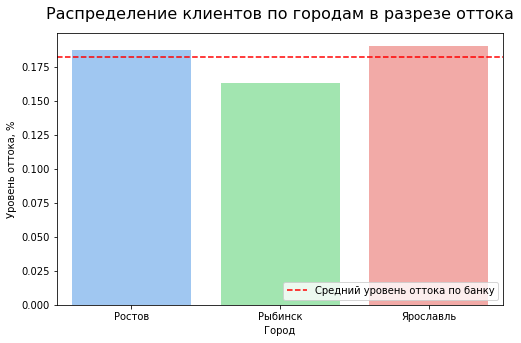

In [22]:
draw_barplot(
    title="Распределение клиентов по городам в разрезе оттока", 
    attribute="city", 
    xlabel="Город"
)

- Доля ушедших клиентов не сильно отличается по филиалам.
- В Ярославле больше всего отточных клиентов, затем идет Ростов и меньше всего в Рыбинске.
- Средний уровень оттока по банку превышен только в двух городах - в Ярославле и Ростове.

#### Пол клиента

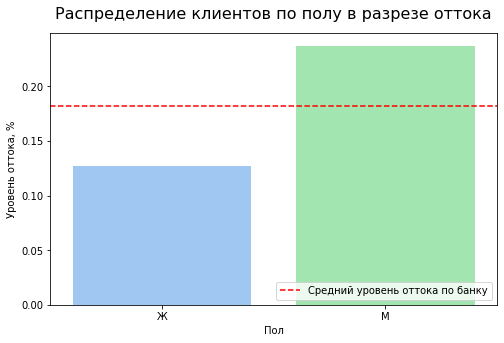

In [23]:
draw_barplot(
    title="Распределение клиентов по полу в разрезе оттока", 
    attribute="gender", 
    xlabel="Пол"
)

- Женщины реже отказываются от услуг банка, чем мужчины.
- Средний уровень оттока по банку превышен только у мужчин.

#### Возраст клиента

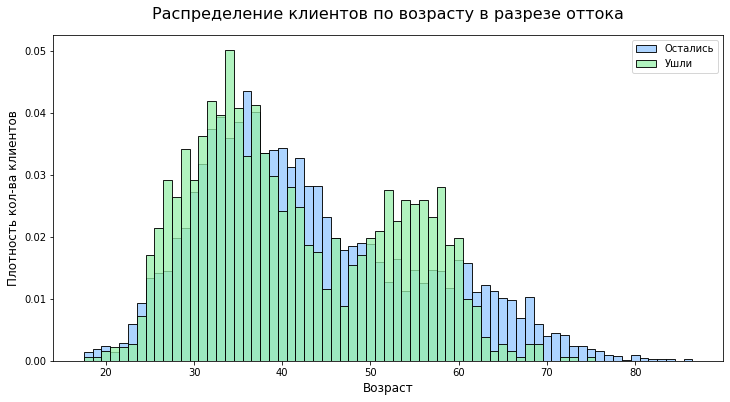

In [24]:
draw_histplot_density(
    title='Распределение клиентов по возрасту в разрезе оттока', 
    attribute='age', 
    xlabel='Возраст'
)

- На графике видны две волны оттока, где значения оттока перекрывают значения оставшихся клиентов - первая с 25 до 35 лет и вторая поменьше - с 50 до 60 лет.
- Пик оттока приходятся на максимум первой волны - 35 лет

#### Баланс на счетах

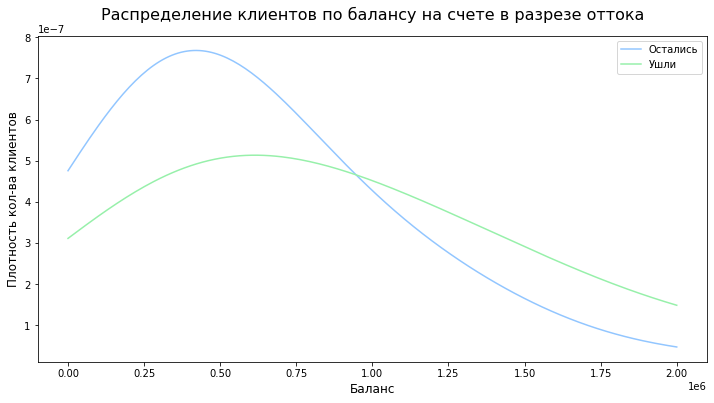

In [25]:
draw_kdeplot(
    title='Распределение клиентов по балансу на счете в разрезе оттока', 
    attribute='balance', 
    xlabel='Баланс'
)

- Резких пиковых значений на графике распределения клиентов по балансу на счете не видно.
- В начале идет небольшой рост с последующим небольшим снижением уровня оттока.

#### Доход клиента

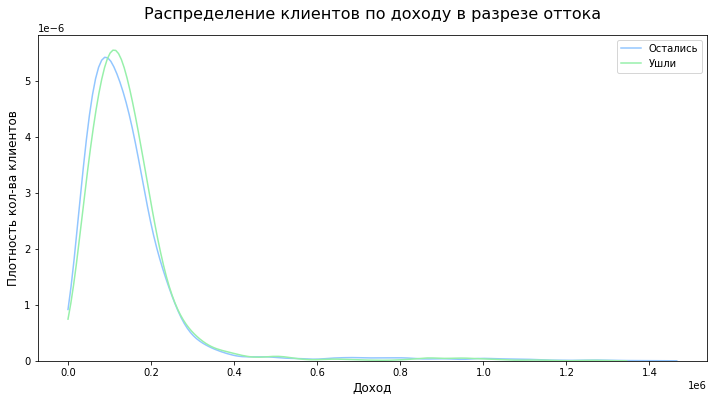

In [26]:
draw_kdeplot(
    title='Распределение клиентов по доходу в разрезе оттока', 
    attribute='estimated_salary', 
    xlabel='Доход'
)

Уровень оттока у клиентов с разным доходом отличается незначительно.

#### Наличие кредитной карты

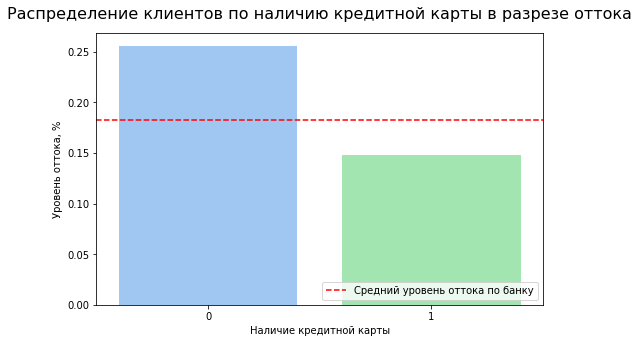

In [27]:
draw_barplot(
    title="Распределение клиентов по наличию кредитной карты в разрезе оттока", 
    attribute="credit_card", 
    xlabel="Наличие кредитной карты"
)

Средний уровень оттока по банку превышают клиенты, которые не пользуются кредитной картой.

####  Баллы собственности

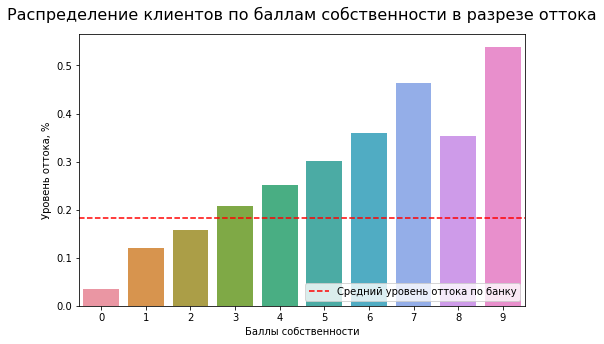

In [28]:
draw_barplot(
    title="Распределение клиентов по баллам собственности в разрезе оттока", 
    attribute="equity", 
    xlabel="Баллы собственности"
)

Средний уровень оттока по банку превышают клиенты, у которых более 3х баллов собственности.

####  Банковские продукты

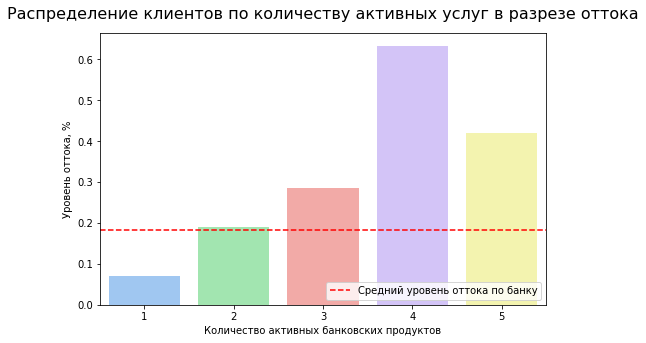

In [29]:
draw_barplot(
    title="Распределение клиентов по количеству активных услуг в разрезе оттока", 
    attribute="products", 
    xlabel="Количество активных банковских продуктов"
)

Средний уровень оттока по банку превышают клиенты, у которых 3 и более активных банковских продукта.

#### Последняя активность

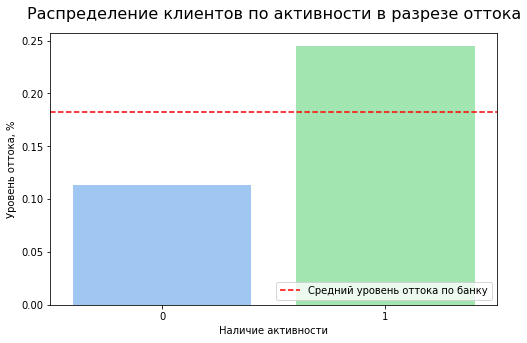

In [30]:
draw_barplot(
    title="Распределение клиентов по активности в разрезе оттока", 
    attribute="last_activity", 
    xlabel="Наличие активности"
)

Средний уровень оттока по банку превышают активные клиенты.

#### Баллы скоринга

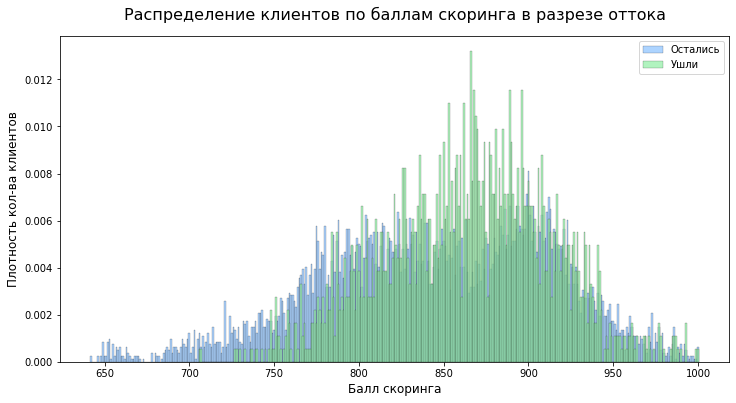

In [31]:
draw_histplot_density(
    title='Распределение клиентов по баллам скоринга в разрезе оттока', 
    attribute='score', 
    xlabel='Балл скоринга'
)

Наибольший уровень оттока в зависимости от кредитного рейтинга виден на интервале от 850 до 920 баллов скоринга.

#### Выводы

Выявлены следующие значения и интервалы признаков с повышенным оттоком:
- Города - Ярославль и Ростов.
- Пол - мужчины.
- Возраст - две группы: с 25 до 35 лет и с 50 до 60 лет.
- Не пользуются кредитной картой.
- Более 3х баллов собственности.
- Три и более активных банковских продукта.
- Активные клиенты.
- Кредитный рейтинг в диапазоне от 850 до 920 баллов.

### Анализ портретов клиентов в разрезе оттока

Составим портреты клиентов по статусу оттока в виде сводной таблицы: `значения оттока` х `признаки`, значения - `мера центральной тенденции`
- `мера центральной тенденции` для непрерывных признаков - среднее арифметическое
- `мера центральной тенденции` для дискретных признаков - медиана
- `мера центральной тенденции` для категориальных признаков - мода
- дополнительный признак - относительная разница между непрерывными признаками

In [32]:
# Расчитаем меры центральной тенденции
df_churn = df.groupby('churn').agg({
    'score':            'mean',          # непрерывный признак
    'age':              'mean',          # непрерывный признак
    'estimated_salary': 'mean',          # непрерывный признак
    'balance':          'mean',          # непрерывный признак
    'products':         'median',        # дискретный признак
    'equity':           'median',        # дискретный признак
    'city':             pd.Series.mode,  # категориальный признак
    'gender':           pd.Series.mode,  # категориальный признак
    'credit_card':      'median',        # дискретный признак
    'last_activity':    'median'         # дискретный признак
})

# Расчитаем относительную разницу мер центральной тенденции для непрерывных признаков
continuous_signs = ['score', 'age', 'estimated_salary', 'balance']
result = []
for i, v in df_churn.items():    
    if i in continuous_signs:
        rate_val = (v[1] / v[0] - 1) * 100
        result.append(rate_val)
    else:
        result.append(float('nan'))
churn_rate = pd.Series(result, index=df_churn.iloc[1].index)

# Соединим все в сводную таблицу
pd.concat({
        'Остались':   df_churn.iloc[0],
        'Ушли':       df_churn.iloc[1],
        'Разница, %': churn_rate
    },
    axis=1
).sort_values('Разница, %', ascending=False, key=abs)

,Остались,Ушли,"Разница, %"
balance,"733,031.63","1,134,458.21",54.76
age,43.02,41.43,-3.70
score,845.40,863.36,2.13
estimated_salary,"147,674.64","148,357.48",0.46
products,2,2,NaN
equity,3,4,NaN
city,Ярославль,Ярославль,NaN
gender,Ж,М,NaN
credit_card,1,1,NaN
last_activity,0,1,NaN


Значения мер центральной тенденции показывают:
- Количество используемых продуктов `products` у ушедших и оставшихся клиентов одинаковая, как и количество кредитных карт `credit_card`
- Количество баллов собственности `equity` у ушедших клиентов выше (4 балла) чем у оставшихся (3 балла)
- Наибольшая отточность проявляется в Ярославле
- Мужчины чаще уходят, чем женщины
- Ушедшие клиенты чаще были недавно активными
- Баланс на счете `balance` у ушедших клиентов на 55% выше, чем у оставшихся
- Возраст `age`, кредитный рейтинг `score` и доход `estimated_salary` у оставшихся и ушедших клиентов отличается не более, чем на 4%

**Портрет типичного лояльного клиента:**
- женщина из Ярославля с балансом на счете порядка 733 тыс. у.е.
- в возрасте 43 лет и зарплатой порядка 147 тыс. у.е.
- имеет одну кредитную карту
- пользуется двумя банковскими продуктами
- имеет кредитный рейтинг 845 баллов и три балла собственности

**Портрет типичного отточного клиента:**
- мужчина из Ярославля с балансом на счете порядка 1,1 млн. у.е.
- в возрасте 41 года и зарплатой порядка 148 тыс. у.е.
- имеет одну кредитную карту
- пользуется двумя банковскими продуктами
- имеет кредитный рейтинг 845 баллов и 4 балла собственности

### Корреляционный анализ оттока

Построим тепловую карту корреляции признаков клиентов банка

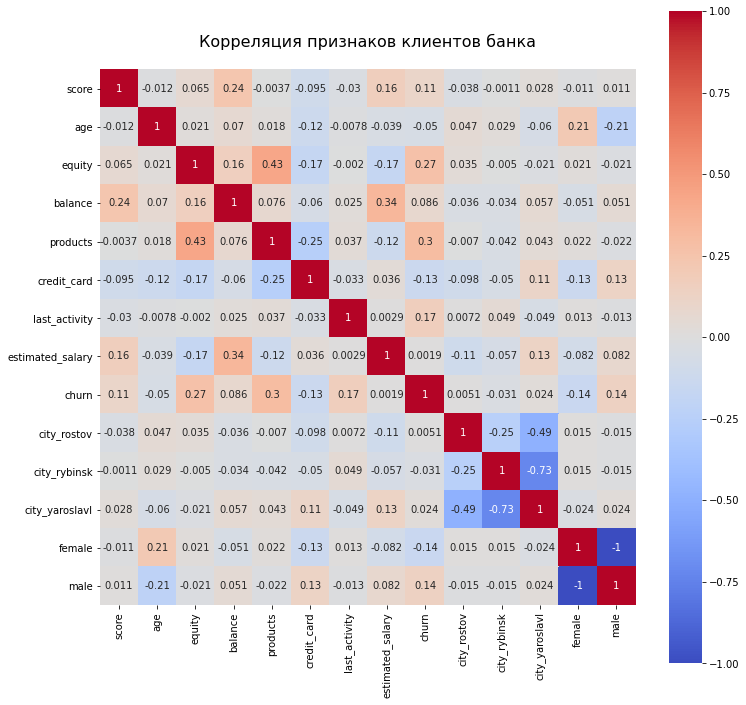

In [33]:
plt.figure(figsize=(12, 12))
plt.title('Корреляция признаков клиентов банка', fontsize=16, y=1.03)
df_corr = df.drop(columns=['user_id', 'city', 'gender'], axis=1).corr()
sns.heatmap(df_corr, annot = True, square=True, cmap='coolwarm')
plt.show()

In [34]:
df_churn_corr = df_corr['churn'].apply('abs').sort_values(axis=0, ascending=False)

print("Столбцы до переименования\n", df_churn_corr.index)
df_churn_corr.index = [
   'Отток', 'Банковские продукты', 'Баллы собственности', 'Активность', 'Мужской пол', 'Женский пол',
   'Наличие кредитной карты', 'Кредитный рейтинг', 'Баланс', 'Возраст', 'Филиал в Рыбинске',
   'Филиал в Ярославле', 'Филиал в Ростове', 'Доход'
]
print("\nСтолбцы после переименования\n", df_churn_corr.index)

Столбцы до переименования
 Index(['churn', 'products', 'equity', 'last_activity', 'male', 'female',
       'credit_card', 'score', 'balance', 'age', 'city_rybinsk',
       'city_yaroslavl', 'city_rostov', 'estimated_salary'],
      dtype='object')

Столбцы после переименования
 Index(['Отток', 'Банковские продукты', 'Баллы собственности', 'Активность',
       'Мужской пол', 'Женский пол', 'Наличие кредитной карты',
       'Кредитный рейтинг', 'Баланс', 'Возраст', 'Филиал в Рыбинске',
       'Филиал в Ярославле', 'Филиал в Ростове', 'Доход'],
      dtype='object')


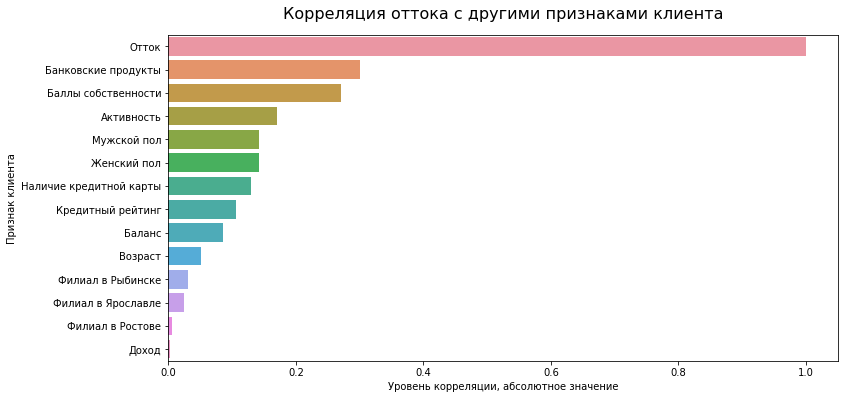

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Корреляция оттока с другими признаками клиента", fontsize=16, y=1.03)
sns.barplot(x=df_churn_corr.values, y=df_churn_corr.index)    
ax.set_xlabel('Уровень корреляции, абсолютное значение')
ax.set_ylabel('Признак клиента')
plt.show()

По шкале Чеддока можно интерпретировать полученные значения корреляции оттока клиентов с остальными признаками следующим образом:
- `< 0.1` - связь отсутствует с признаками:
    - возраст
    - баланс на счете
    - доход
    - филиал обслуживания
- `0.1 - 0.3` - присутствует слабая связь с признаками:
    - кредитный рейтинг
    - баллы собственности
    - количество активных банковских продуктов
    - наличие кредитной карты
    - наличие активности
    - пол

### Выводы

1. Выявлены следующие значения и интервалы признаков с повышенным оттоком:
    - Города - Ярославль и Ростов.
    - Пол - мужчины.
    - Возраст - две группы: с 25 до 35 лет и с 50 до 60 лет.
    - Не пользуются кредитной картой.
    - Более 3х баллов собственности.
    - Три и более активных банковских продукта.
    - Активные клиенты.
    - Кредитный рейтинг в диапазоне от 850 до 920 баллов.


2. Значения мер центральной тенденции показывают:
    - Количество используемых продуктов у ушедших и оставшихся клиентов одинаковая, как и количество кредитных карт.
    - Количество баллов собственности у ушедших клиентов выше (4 балла) чем у оставшихся (3 балла).
    - Наибольшая отточность проявляется в Ярославле.
    - Мужчины чаще уходят, чем женщины.
    - Ушедшие клиенты чаще были недавно активными.
    - Баланс на счете у ушедших клиентов на 55% выше, чем у оставшихся.
    - Возраст, кредитный рейтинг и доход у оставшихся и ушедших клиентов отличается не более, чем на 4%.


3. Корреляционный анализ показал отсутствие взаимосвязи либо наличие очень слабой связи между оттоком и остальными признаками клиента.

## Проверка гипотез

### Доходы оставшихся и ушедших клиентов равны

Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
- **H0 (нулевая гипотеза)**: доходы оставшихся и ушедших клиентов равны.
- **H1 (альтернативная гипотеза)**: доходы оставшихся и ушедших клиентов не равны.

**Проверим применимость t-test для проверки гипотезы**

In [36]:
df_churn_0 = df[df['churn'] == 0]['estimated_salary']
df_churn_1 = df[df['churn'] == 1]['estimated_salary']

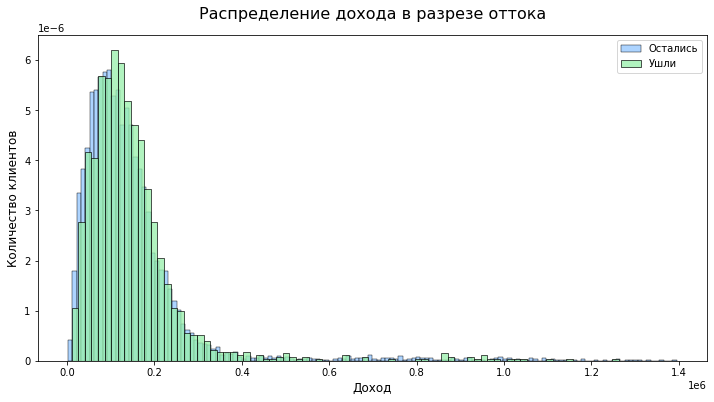

In [37]:
# Посмотрим на распределение дохода для ушедших и оставшихся клиентов
plt.figure(figsize=(12,6))
plt.title("Распределение дохода в разрезе оттока", fontsize=16, y=1.03)
sns.histplot(df_churn_0, color='#92c6ff', stat='density');
sns.histplot(df_churn_1, color='#97f0aa', stat='density');
plt.legend(['Остались', 'Ушли'])
plt.xlabel("Доход", fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.show()

Распределение не выглядет как нормальное, но для надежности еще проведем Shapiro-Wilk тест обоих датасетов.
- H0 (нулевая гипотеза): датасет имеет нормальное распределение.
- H1 (альтернативная гипотеза): датасет не имеет нормальное распределение.

In [38]:
print("Датасет `df_churn_0`")
shapiro_test_stat, p_value = st.shapiro(df_churn_0)
print('P-value: ', p_value)
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  
     
      
print("\nДатасет `df_churn_1`")
shapiro_test_stat, p_value = st.shapiro(df_churn_1)
print('P-value: ', p_value)
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')        

Датасет `df_churn_0`
P-value:  0.0
Отвергаем нулевую гипотезу

Датасет `df_churn_1`
P-value:  0.0
Отвергаем нулевую гипотезу


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



Отвергаем нулевую гипотезу для обоих датасетов, что датасет имеет нормальное распределение.

Так же проверим дисперсию в датасетах

In [39]:
print("Дисперсия в датасете `df_churn_0`:", df_churn_0.var())
print("Дисперсия в датасете `df_churn_1`:", df_churn_1.var())

Дисперсия в датасете `df_churn_0`: 20358839437.943962
Дисперсия в датасете `df_churn_1`: 15112272166.883385


Так же необходимо проверить выбросы в датасетах - данная проверка, в дополнение к проверкам распределения и дисперсии, будет определяющим критерием возможности применения t-test для проверки гипотезы.

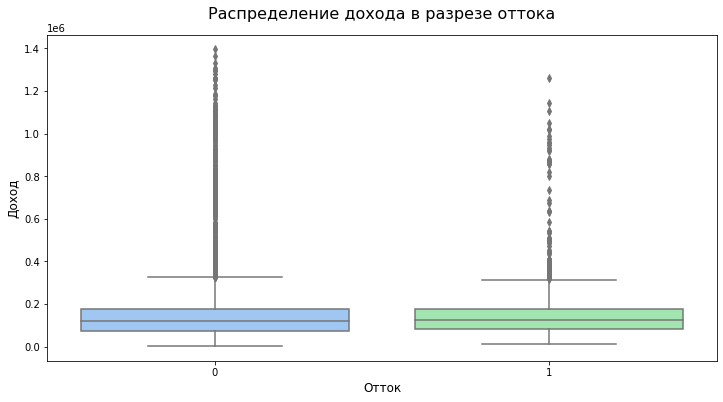

In [40]:
plt.figure(figsize=(12,6))
plt.title("Распределение дохода в разрезе оттока", fontsize=16, y=1.03)
sns.boxplot(data=df, x='churn', y='estimated_salary')
plt.xlabel("Отток", fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.show()

- На графике видим значительное количество выбросов.
- На основании трех проверок - распределение значений в выборках не является нормальным, дисперсии не равны и присутствуют выбросы, можем сделать вывод о неприменимости ttest для проверки гипотезы.
- Для ненормального распределения выборок возьмем U-критерий Манна-Уитни и проведем u-test.

In [41]:
res = st.mannwhitneyu(df_churn_0, df_churn_1)
print('P-value: ', '{0:.5f}'.format(res.pvalue))

if res.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

P-value:  0.00017
Отвергаем нулевую гипотезу


- Отвергаем нулевую гипотезу, что доходы оставшихся и ушедших клиентов равны.
- Есть основания полагать, что доходы оставшихся и ушедших клиентов не равны.

### Отток зависит от города филиала

Проверим гипотезу о влиянии города филиала на отток клиентов банка.
- **H0 (нулевая гипотеза)**: отток зависит от города филиала;
- **H1 (альтернативная гипотеза)**: отток не зависит от города филиала.

Выборки будут являються набором бинарных значений, поэтому применим z-test для проверки гипотезы.

In [42]:
df[df['churn']==1]['churn'].count()

1818

In [43]:
# Критический уровень статистической значимости
alpha = 0.05

# Средний уровень оттока по банку
churn_mean = df['churn'].mean()
# количество отточных клиентов всего
successes_2 = df[df['churn']==1]['churn'].count()
# общее количество клиентов всего
nobs_2 = df['churn'].count()

for city in ['Ростов', 'Рыбинск', 'Ярославль']:
    # количество отточных клиентов города
    successes_1 = df[(df['city']==city) & (df['churn']==1)]['churn'].count()
    # общее количество клиентов города
    nobs_1 = df[df['city']==city]['churn'].count()         
    
    z_stat, pval = proportions_ztest([successes_1, successes_2], [nobs_1, nobs_2], churn_mean)

    print('P-value:', '{0:0.3f}'.format(pval))

    if pval < alpha:
        print(f"Отвергаем нулевую гипотезу. Город: {city}\n")
    else:
        print(f"Не получилось отвергнуть нулевую гипотез. Город: {city}\n")

P-value: 0.000
Отвергаем нулевую гипотезу. Город: Ростов

P-value: 0.000
Отвергаем нулевую гипотезу. Город: Рыбинск

P-value: 0.000
Отвергаем нулевую гипотезу. Город: Ярославль



- Нет оснований пологать, что отток зависит от города филиала.

### Выводы

- Есть основания полагать, что доходы оставшихся и ушедших клиентов не равны.
- Нет оснований полагать, что отток зависит от города филиала.

## Обобщение признаков, влияющих на отток

На основе проведенного исследовательского анализа данных и проверки отдельных гипотез, обобщим признаки, сопутствующие повышенному оттоку клиентов.
- Города - Ярославль (в приоритете) и Ростов (в меньшем приоритете).
- Пол - мужчины.
- Возраст - две группы: с 25 до 35 лет и с 50 до 60 лет.
- Не пользуются кредитной картой.
- Более 3х баллов собственности.
- Три и более активных банковских продукта.
- Активные клиенты.
- Кредитный рейтинг в диапазоне от 850 до 920 баллов.
- Баланс на счете у ушедших клиентов на 55% выше, чем у оставшихся.

Выделенные значения и интервалы признаков используем для дальнейшей сегментации клиентов.

## Сегментация

- На основе обобщенных признаков, влияющих на отток, выделим три отдельных сегмента клиентов.
- Убедимся, что каждый выделенный сегмент удовлетворяет следующим требованиям:
    - В сегменте более 500 клиентов.
    - Уровень оттока в сегменте выше, чем в среднем по банку - 18.2%.

### Сегмент №1 - Зрелый и надежный

Признаки клиента в сегменте:
- Возраст от 45 до 60 лет
- Кредитный рейтинг более от 850 до 925 баллов
- Активный

In [44]:
signs_query = 'age >= 45 and age <= 60 and score > 850 and score < 925 and last_activity == 1'
print ('Общее количество клиентов: ', df.query(signs_query)['user_id'].count())
print ('Количество отточных клиентов: ', df.query(signs_query + ' and churn == 1')['user_id'].count())
print('Уровень оттока: ', (
    df.query(signs_query + ' and churn == 1')['user_id'].count() / 
    df.query(signs_query)['user_id'].count() * 100).round(1), '%')

Общее количество клиентов:  502
Количество отточных клиентов:  190
Уровень оттока:  37.8 %


Возможно, данному сегменту следует предложить целевой кредит для пенсионеров.

### Сегмент №2 - На пути к успеху

Признаки клиента в сегменте:
- Возраст от 25 до 45 лет
- Баланс более 850,000
- Баллы собственности более 3
- Активный

In [45]:
signs_query = '25 <= age <= 35 and equity > 3 and last_activity == 1'

print ('Общее количество клиентов: ', df.query(signs_query)['user_id'].count())
print ('Количество отточных клиентов: ', df.query(signs_query + ' and churn == 1')['user_id'].count())
print ('Уровень оттока: ', (
    df.query(signs_query + ' and churn == 1')['user_id'].count() / 
    df.query(signs_query)['user_id'].count() * 100).round(1), '%')

Общее количество клиентов:  723
Количество отточных клиентов:  365
Уровень оттока:  50.5 %


Клиентам из данного сегмента можно предложить специальные условия по накопительным счетам, различные залоговые кредиты и страхование имущества.

### Сегмент №3 - Ответственный ярославец

Признаки клиента в сегменте:
- Город Ярославль
- Нет кредитной карты
- Активный

In [46]:
signs_query = 'credit_card == 0 and last_activity == 1 and city == "Ярославль"'

print ('Общее количество клиентов: ', df.query(signs_query)['user_id'].count())
print ('Количество отточных клиентов: ', df.query(signs_query + ' and churn == 1')['user_id'].count())
print ('Уровень оттока: ', (
    df.query(signs_query + ' and churn == 1')['user_id'].count() / 
    df.query(signs_query)['user_id'].count() * 100).round(1), '%')

Общее количество клиентов:  843
Количество отточных клиентов:  343
Уровень оттока:  40.7 %


Вероятно, клиентам из текущего сегмента следует предложить кредитную карту, либо дебетовую карту с выгодным с кэшбэком.

### Приоритезация сегментов

За параметр приоретизации возьмем количество отточных клиентов - чем больше количество, тем выше приоритет для взятия в работу отделом маркетинга. Т.е. на первое место мы ставим количество клиентов, на которых будет направлена дальнейшая маркетинговая активность.
- 1й приоритет - сегмент "На пути к успеху", количество отточных клиентов 365.
- 2й приоритет - сегмент "Ответственный ярославец", количество отточных клиентов 343.
- 3й приоритет - сегмент "Зрелый и надежный", количество отточных клиентов 190.


### Выводы

- Выделили три сегмента:
	1. "Зрелый и надежный" - активные клиенты в возрасте от 45 до 60 лет с кредитным рейтингом от 850 до 925 баллов.
	2. "На пути к успеху" - активные клиенты в возрасте от 25 до 35 лет с собственностью на более 3 баллов.
	3. "Ответственный ярославец" - активные ярославцы без кредитной карты.
- Приоритезировали на основе количества отточных клиентов:
    - 1й приоритет - сегмент "На пути к успеху", количество отточных клиентов 365.
    - 2й приоритет - сегмент "Ответственный ярославец", количество отточных клиентов 343.
    - 3й приоритет - сегмент "Зрелый и надежный", количество отточных клиентов 190. 

## Выводы и рекомендации

### Выводы

**Обзор данных**
- Размер датасета - 12 колонок, 10 000 строк
- Наблюдаются пропуски в колонках `age` и `balance`
- Назвавния колонок в разном регистре - необходимо будет привести их к единому стилю 
- Колонки `score` и `age` необходимо привести к целочисленному типу данных
- Отрицательные значения отсутствуют
- Средний отток по банку - 18,2%

**Предобработка данных**
- Привели наименования столбцов к единому стилю.
- Привели колонки `score` и `age` к целочисленному типу данных.
- Закодировали значения столбцов `city` и `gender` для оценки корреляции в следующих разделах.
- Классифицировали пропуски в столбце `age` как `MCAR` и удалили их.
- Классифицировали пропуски в столбце `balance` как `MNAR` и оставили их.
- Удалили одну строку с аномальным нулевым количеством банковских продуктов.
- Полные дубликаты строк в датасете не обнаружили.
- Обнаружили неявные дубликаты по столбцу `user_id`, но они не дублируются в рамках одного города - поэтому их оставили в датасете.

**Исследовательский анализ данных, EDA**
1. Выявлены следующие значения и интервалы признаков с повышенным оттоком.
    - Города - Ярославль и Ростов.
    - Пол - мужчины.
    - Возраст - две группы: с 25 до 35 лет и с 50 до 60 лет.
    - Не пользуются кредитной картой.
    - Более 3х баллов собственности.
    - Три и более активных банковских продукта.
    - Активные клиенты.
    - Кредитный рейтинг в диапазоне от 850 до 920 баллов.


2. Значения мер центральной тенденции показали следующее.
    - Количество используемых продуктов у ушедших и оставшихся клиентов одинаковая, как и количество кредитных карт.
    - Количество баллов собственности у ушедших клиентов выше (4 балла) чем у оставшихся (3 балла).
    - Наибольшая отточность проявляется в Ярославле.
    - Мужчины чаще уходят, чем женщины.
    - Ушедшие клиенты чаще были недавно активными.
    - Баланс на счете у ушедших клиентов на 55% выше, чем у оставшихся.
    - Возраст, кредитный рейтинг и доход у оставшихся и ушедших клиентов отличается не более, чем на 4%.


3. Корреляционный анализ показал отсутствие взаимосвязи либо наличие очень слабой связи между оттоком и остальными признаками клиента.


**Проверка гипотез**
- Есть основания полагать, что доходы оставшихся и ушедших клиентов не равны.
- Нет оснований полагать, что отток зависит от города филиала.


**Обобщение признаков, влияющих на отток**
- Города - Ярославль (в приоритете) и Ростов (в меньшем приоритете).
- Пол - мужчины.
- Возраст - две группы: с 25 до 45 лет и с 48 до 60 лет.
- Не пользуются кредитной картой.
- Более 3х баллов собственности.
- Три и более активных банковских продукта.
- Активные клиенты.
- Кредитный рейтинг в диапазоне от 850 до 920 баллов.
- Баланс на счете у ушедших клиентов на 55% выше, чем у оставшихся.


**Сегментация**
- Выделили три сегмента:
	1. "Зрелый и надежный" - активные клиенты в возрасте от 45 до 60 лет с кредитным рейтингом от 850 до 925 баллов.
	2. "На пути к успеху" - активные клиенты в возрасте от 25 до 35 лет с собственностью на более 3 баллов.
	3. "Ответственный ярославец" - активные ярославцы без кредитной карты.
- Приоритезировали на основе количества отточных клиентов:
    - 1й приоритет - сегмент "На пути к успеху", количество отточных клиентов 365.
    - 2й приоритет - сегмент "Ответственный ярославец", количество отточных клиентов 343.
    - 3й приоритет - сегмент "Зрелый и надежный", количество отточных клиентов 190. 

### Рекомендации

- Для клиентов из сегмента "Зрелый и надежный" следует предложить целевой кредит для пенсионеров.
- Для клиентов из сегмента "На пути к успеху" можно предложить специальные условия по накопительным счетам, различные залоговые кредиты и страхование имущества.
- Для сегмента "Ответственный ярославец" следует предложить кредитную карту, либо дебетовую карту с выгодным с кэшбэком.